C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_37712\350214145.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


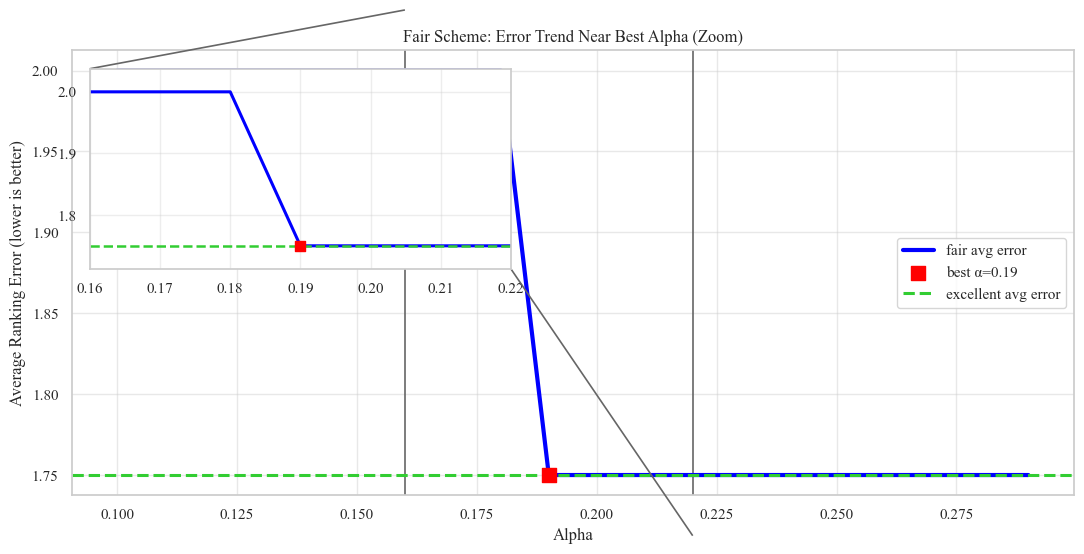

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

df = pd.read_csv(CSV_PATH)

needed = {"alpha", "fair_avg_error"}
if not needed.issubset(df.columns):
    raise ValueError(f"CSV缺少必要列：{needed}，你现在列名是：{list(df.columns)}")

df["alpha"] = pd.to_numeric(df["alpha"], errors="coerce")
df["fair_avg_error"] = pd.to_numeric(df["fair_avg_error"], errors="coerce")
if "excellent_avg_error" in df.columns:
    df["excellent_avg_error"] = pd.to_numeric(df["excellent_avg_error"], errors="coerce")

df = df.dropna(subset=["alpha", "fair_avg_error"]).sort_values("alpha")

if "is_best_alpha" in df.columns and (df["is_best_alpha"] == 1).any():
    best = df.loc[df["is_best_alpha"] == 1].iloc[0]
else:
    best = df.loc[df["fair_avg_error"].idxmin()]

best_alpha = float(best["alpha"])
best_err = float(best["fair_avg_error"])

has_excellent = "excellent_avg_error" in df.columns and df["excellent_avg_error"].notna().any()
excellent_y = float(df["excellent_avg_error"].dropna().iloc[0]) if has_excellent else None

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "Times New Roman",
    "axes.unicode_minus": False,
})

fig, ax = plt.subplots(figsize=(11, 5.5))

ax.plot(
    df["alpha"], df["fair_avg_error"],
    color="blue", linewidth=3.0, label="fair avg error"
)

ax.scatter(
    [best_alpha], [best_err],
    color="red", s=90, marker="s", zorder=5,
    label=f"best α={best_alpha:.2f}"
)

if has_excellent:
    ax.axhline(excellent_y, color="limegreen", linestyle="--", linewidth=2.2, label="excellent avg error")

ax.set_title("Fair Scheme: Error Trend Near Best Alpha (Zoom)")
ax.set_xlabel("Alpha")
ax.set_ylabel("Average Ranking Error (lower is better)")

ax.grid(True, which="major", alpha=0.45)
ax.legend(loc="center right", frameon=True)

alphas = df["alpha"].to_numpy()
if len(alphas) >= 2:
    step = np.median(np.diff(alphas))
else:
    step = 0.01

x1, x2 = best_alpha - inset_half_width, best_alpha + inset_half_width

axins = inset_axes(ax, width="42%", height="45%", loc="upper left", borderpad=1.2)
axins.plot(df["alpha"], df["fair_avg_error"], color="blue", linewidth=2.2)
axins.scatter([best_alpha], [best_err], color="red", s=60, marker="s", zorder=5)

if has_excellent:
    axins.axhline(excellent_y, color="limegreen", linestyle="--", linewidth=1.8)

axins.set_xlim(x1, x2)

sub = df[(df["alpha"] >= x1) & (df["alpha"] <= x2)]
if len(sub) >= 2:
    y_min, y_max = sub["fair_avg_error"].min(), sub["fair_avg_error"].max()
    pad = 0.15 * (y_max - y_min + 1e-9)
    axins.set_ylim(y_min - pad, y_max + pad)

axins.grid(True, alpha=0.35)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", lw=1.2)

plt.tight_layout()
plt.savefig("alpha_zoom_with_inset.png", dpi=300, bbox_inches="tight")
plt.show()


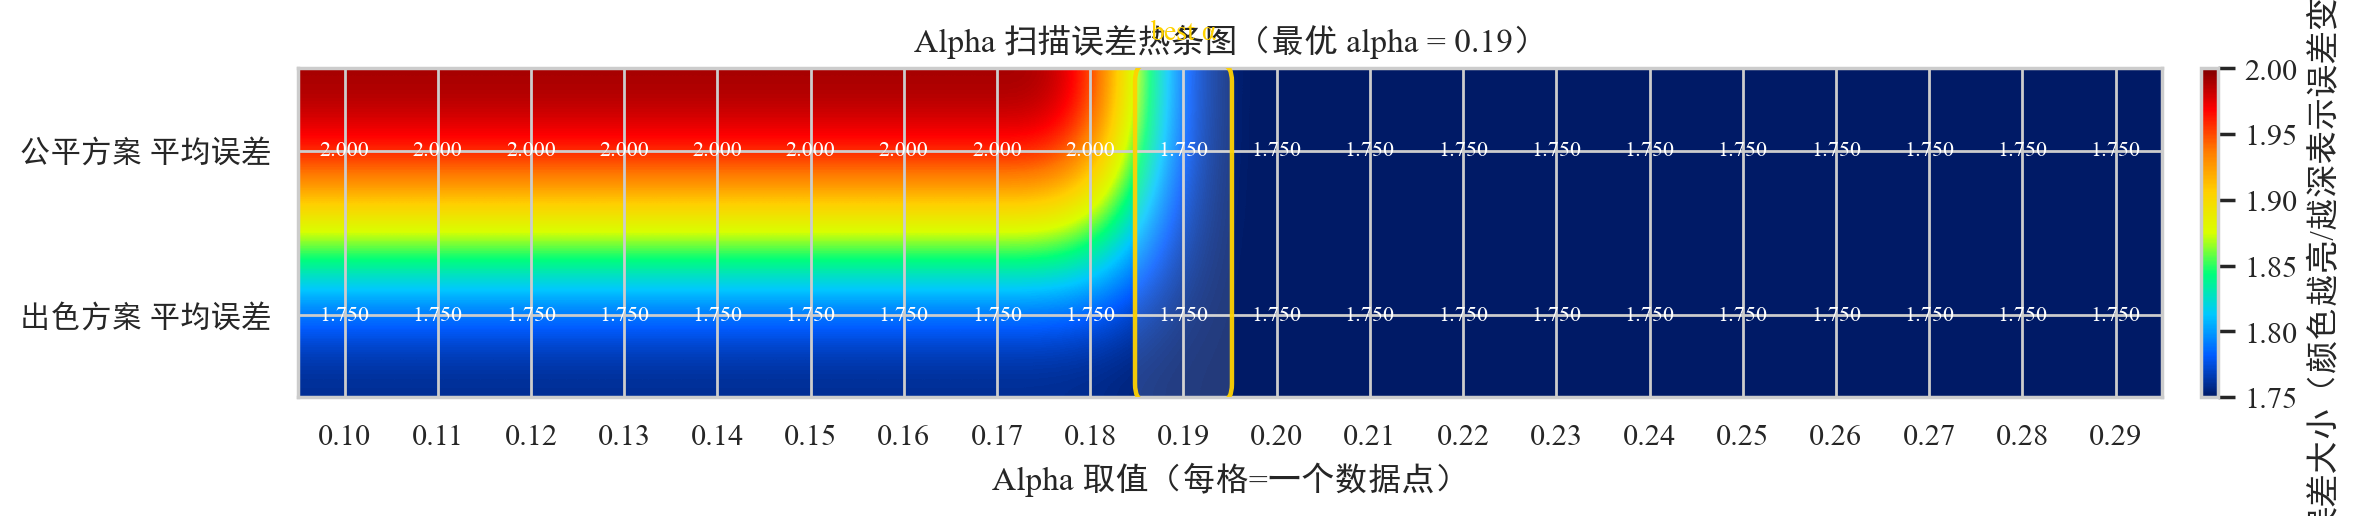

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


from matplotlib.colors import LinearSegmentedColormap

corneal_cmap = LinearSegmentedColormap.from_list(
    "corneal_topo",
    [
    ],
    N=256
)




alphas = df["alpha"].to_numpy()
fair = df["fair_avg_error"].to_numpy()
exc  = df["excellent_avg_error"].to_numpy()

if "is_best_alpha" in df.columns and df["is_best_alpha"].sum() > 0:
    best_idx = int(np.where(df["is_best_alpha"].to_numpy() == 1)[0][0])
else:
    best_idx = int(np.argmin(fair))
best_alpha = alphas[best_idx]

mpl.rcParams["font.family"] = ["Times New Roman", "SimHei", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False


fig, ax = plt.subplots(figsize=(12, 2.8), dpi=200)





im = ax.imshow(
    Z, aspect="auto", interpolation="bicubic",
    cmap=corneal_cmap
)

vmin, vmax = Z.min(), Z.max()
im = ax.imshow(Z, aspect="auto", interpolation="bicubic",
               cmap=corneal_cmap, vmin=vmin, vmax=vmax)



ax.set_yticks([0, 1])
ax.set_yticklabels(["公平方案 平均误差", "出色方案 平均误差"])

ax.set_xticks(np.arange(len(alphas)))
ax.set_xticklabels([f"{a:.2f}" for a in alphas], rotation=0)
ax.set_xlabel("Alpha 取值（每格=一个数据点）")

for r in range(Z.shape[0]):
    for c in range(Z.shape[1]):
        ax.text(c, r, f"{Z[r,c]:.3f}", ha="center", va="center",
                fontsize=8, color="white")





from matplotlib.patches import FancyBboxPatch

from matplotlib.patches import FancyBboxPatch

col = FancyBboxPatch(
    (best_idx - 0.5, -0.5), 1, Z.shape[0],
    boxstyle="round,pad=0.02,rounding_size=0.10",
    edgecolor="none",
    zorder=2
)
ax.add_patch(col)

outline = FancyBboxPatch(
    (best_idx - 0.5, -0.5), 1, Z.shape[0],
    boxstyle="round,pad=0.02,rounding_size=0.10",
    fill=False,
    zorder=3
)
ax.add_patch(outline)

ax.text(
    best_idx, -0.72, "best α",
    ha="center", va="center",
    zorder=4
)











ax.set_title(f"Alpha 扫描误差热条图（最优 alpha = {best_alpha:.2f}）")

cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("误差大小（颜色越亮/越深表示误差变化）")

plt.tight_layout()
plt.savefig("alpha_heatstrip.png", bbox_inches="tight")
plt.show()


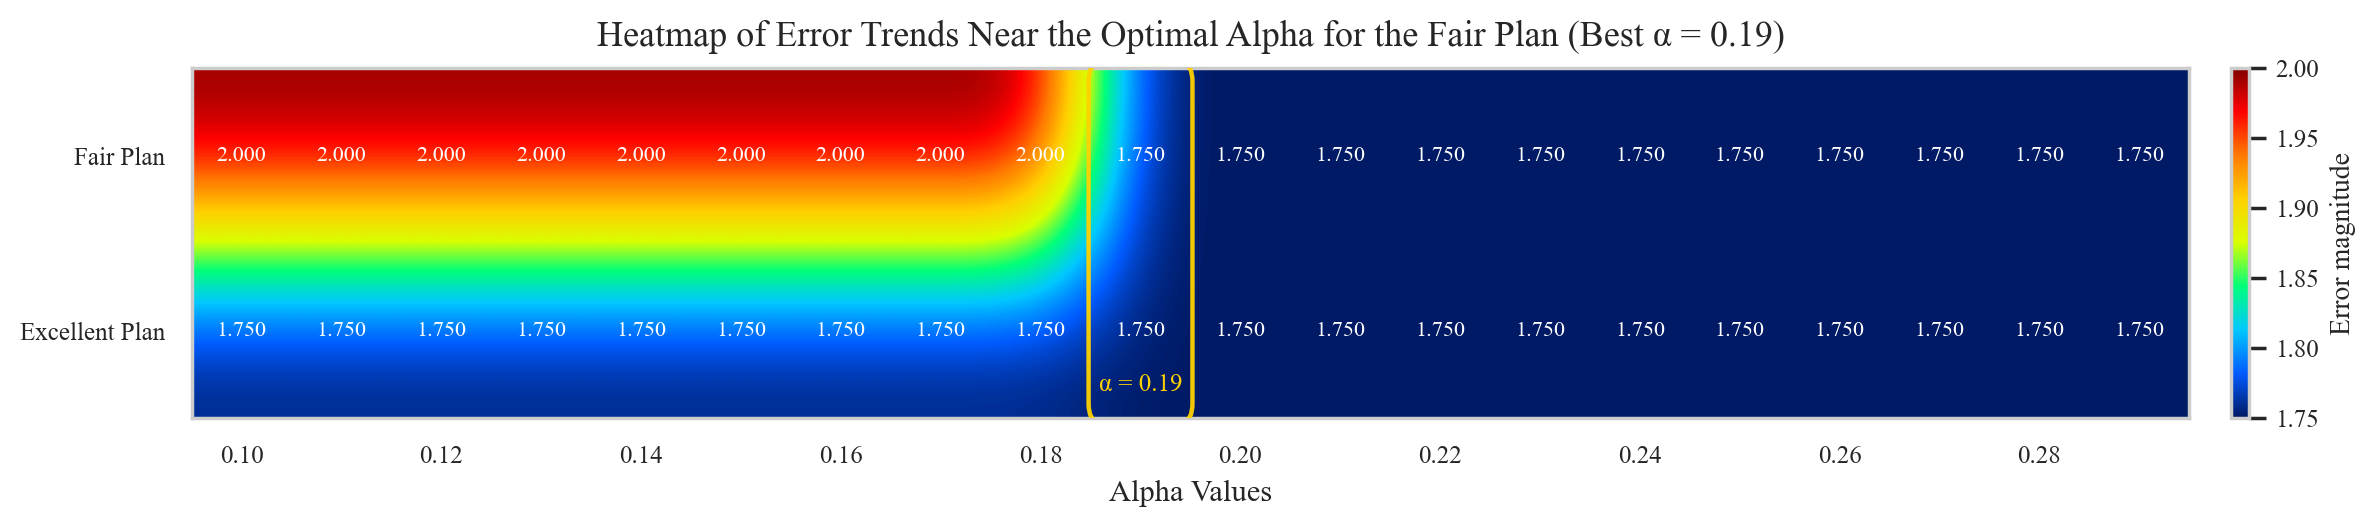

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch

mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

FS_TITLE = 13
FS_LABEL = 11
FS_TICK  = 9
FS_CELL  = 8
FS_CBAR  = 10
FS_NOTE  = 9

corneal_cmap = LinearSegmentedColormap.from_list(
    "corneal_topo",
    [
    ],
    N=256
)

df = pd.read_csv("fig2_alpha_zoom.csv")
alphas = df["alpha"].to_numpy()
fair   = df["fair_avg_error"].to_numpy()
exc    = df["excellent_avg_error"].to_numpy()

if "is_best_alpha" in df.columns and df["is_best_alpha"].sum() > 0:
    best_idx = int(np.where(df["is_best_alpha"].to_numpy() == 1)[0][0])
else:
    best_idx = int(np.argmin(fair))
best_alpha = alphas[best_idx]

Z = np.vstack([fair, exc])

fig, ax = plt.subplots(figsize=(12, 2.7), dpi=200)

vmin, vmax = float(Z.min()), float(Z.max())
im = ax.imshow(
    Z,
    aspect="auto",
    interpolation="bicubic",
    cmap=corneal_cmap,
    vmin=vmin, vmax=vmax,
    zorder=1
)

ax.set_yticks([0, 1])
ax.set_yticklabels(["Fair Plan", "Excellent Plan"], fontsize=FS_TICK)

step = 1
if len(alphas) > 16:
    step = 2
if len(alphas) > 26:
    step = 3

xt = np.arange(len(alphas))
ax.set_xticks(xt[::step])
ax.set_xticklabels([f"{a:.2f}" for a in alphas[::step]], fontsize=FS_TICK)
ax.set_xlabel("Alpha Values", fontsize=FS_LABEL)

ax.set_title(f"Heatmap of Error Trends Near the Optimal Alpha for the Fair Plan (Best α = {best_alpha:.2f})", fontsize=FS_TITLE, pad=8)

for r in range(Z.shape[0]):
    for c in range(Z.shape[1]):
        rgba = im.cmap(im.norm(Z[r, c]))
        brightness = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        txt_color = "black" if brightness > 0.62 else "white"
        ax.text(
            c, r, f"{Z[r, c]:.3f}",
            ha="center", va="center",
            fontsize=FS_CELL,
            color=txt_color,
            zorder=5
        )






from matplotlib.patches import FancyBboxPatch

import matplotlib.transforms as mtransforms


trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)


ax.text(
    best_idx, y_alpha, f"α = {best_alpha:.2f}",
    transform=trans,
    ha="center", va="bottom",
    fontsize=FS_NOTE, color=HL,
    zorder=10,
    clip_on=False
)



outline = FancyBboxPatch(
    (best_idx - 0.5, -0.5), 1, Z.shape[0],
    boxstyle="round,pad=0.02,rounding_size=0.10",
    fill=False,
    zorder=3
)
ax.add_patch(outline)






cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Error magnitude", fontsize=FS_CBAR)
cbar.ax.tick_params(labelsize=FS_TICK)

ax.tick_params(axis="y", labelsize=FS_TICK)
ax.tick_params(axis="x", labelsize=FS_TICK)

plt.tight_layout(pad=0.8)
plt.savefig("alpha_heatstrip.png", bbox_inches="tight")
plt.show()
